# Reconstructing the Z Boson with Jazelle Data

## Introduction
The **SLD Experiment** (Stanford Large Detector) at SLAC ran at the **Z-pole**, meaning the electron-positron collider energy was tuned specifically to create Z bosons (~91.2 GeV).

In this tutorial, we will "rediscover" the Z boson by reconstructing its mass from its decay products.

**The Process:**
1. **Load** the Jazelle Parquet data using `awkward` array.
3. **Select** events with exactly two oppositely charged particles (candidate $Z \to \ell^+ \ell^-$).
4. **Calculate** the invariant mass of the lepton pairs.
5. **Visualize** the resonance peak.

In [1]:
import os
import glob
import numpy as np
import awkward as ak
import vector
import jazelle

vector.register_awkward()

# Load data
datadir = "/global/cfs/projectdirs/m5115/SLD/minidst_translated/parquet"
files = glob.glob(os.path.join(datadir, "*.parquet"))

print(f"Found {len(files)} files to process.")

array_list = [jazelle.from_parquet(f) for f in files]
events = ak.concatenate(array_list)

print(f"Successfully loaded {len(events)} events.")

Found 28 files to process.
Successfully loaded 279505 events.


## Inspecting the Data Structure

The data is hierarchical. Every event contains a header (`IEVENTH`) and various "Families" of data banks. For this analysis, we are interested in **`PHPSUM`** (Physics Particle Summary), which contains the reconstructed momentum vectors for particles detected in the event.

In [2]:
# Inspect the fields available in the PHPSUM bank
print("Available fields in PHPSUM:", events.PHPSUM.fields)

events.PHPSUM

Available fields in PHPSUM: ['id', 'px', 'py', 'pz', 'x', 'y', 'z', 'charge', 'status', 'ptot']


<Array [[{id: 1, px: -1.34, ...}, ...], ...] type='279505 * var * {id: int3...'>

## Creating 4-Vectors
To calculate invariant mass, we need Energy-Momentum vectors.
The `PHPSUM` bank gives us 3-momentum ($p_x, p_y, p_z$).

**Approximation:** Since the Z mass is huge (91 GeV) compared to the mass of leptons (electrons ~0.0005 GeV, muons ~0.1 GeV), we can approximate the daughter particles as **massless** ($m=0$) without affecting the result significantly.

In [3]:
particles = ak.zip({
    'px': events.PHPSUM.px,
    'py': events.PHPSUM.py,
    'pz': events.PHPSUM.pz,
    'm': ak.zeros_like(events.PHPSUM.px),
    'charge': events.PHPSUM.charge
}, with_name="Momentum4D")

## Event Selection
We are looking for the decay channel $Z \to \ell^+ \ell^-$. To find this, we apply three filters:

1.  **Charged Particles:** Neutrals (like photons) are not part of this specific signal.
2.  **Exactly 2 Particles:** To ensure a clean signal for this demo, we select events that have exactly two charged tracks.
3.  **Opposite Charge:** Charge is conserved. A neutral Z boson must decay into a positive (+) and a negative (-) particle.

In [4]:
# 1. Filter for charged particles only
charged_particles = particles[particles.charge != 0]

# 2. Select events with EXACTLY 2 charged particles
# ak.num() counts elements in the nested lists
two_track_mask = (ak.num(charged_particles) == 2)
two_charged_particles = charged_particles[two_track_mask]

# 3. Select pairs with opposite charges (+/-)
# We compare the charge of the first particle [:, 0] vs the second [:, 1]
pair_mask = (two_charged_particles.charge[:, 0] != two_charged_particles.charge[:, 1])
lepton_pairs = two_charged_particles[pair_mask]

print(f"Events remaining after cuts: {len(lepton_pairs)}")

Events remaining after cuts: 24187


## Reconstructing the Z Mass
Using the `vector` library, we can simply **sum** the two daughter particles to reconstruct back the Z boson.

$$P_{Z} = P_{\ell^+} + P_{\ell^-}$$
$$M_{Z} = \sqrt{E_{tot}^2 - \vec{P}_{tot}^2}$$

In [5]:
# Sum the 4-vectors of the pairs to get the parent particle (Z boson)
Z_candidates = ak.sum(lepton_pairs, axis=1)

# Extract the mass
z_mass = Z_candidates.mass

## Visualization

We use `quickstats` to visualize the invariant mass distribution. We expect a sharp peak around **91.2 GeV**, which is the mass of the Z boson.

In [6]:
import importlib.util
if importlib.util.find_spec('quickstats') is None:
    !pip install quickstats

<Axes: xlabel='$M_{\\ell \\bar{\\ell}}$ [GeV]', ylabel='Events / 3 GeV'>

<Figure size 640x480 with 0 Axes>

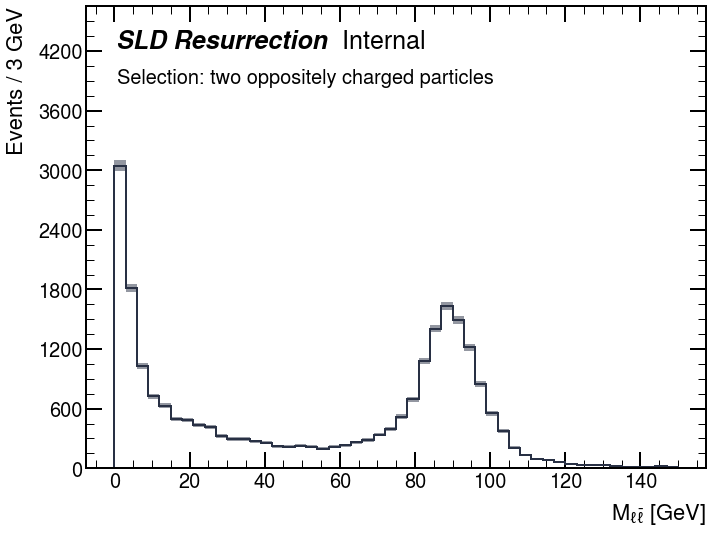

In [7]:
import pandas as pd
from quickstats.plots import VariableDistributionPlot

df = pd.DataFrame({'Z_mass': z_mass})

analysis_label_options = {
    'colab': 'SLD Resurrection',
    'energy': None,
    'lumi': None,
    'extra_text': "Selection: two oppositely charged particles"
}

# 3. Initialize Plotter
plotter = VariableDistributionPlot(df, analysis_label_options=analysis_label_options)

# 4. Draw the Z Peak
plotter.draw(
    'Z_mass',
    xlabel=r'$M_{\ell \bar{\ell}}$',
    bin_range=(0, 150),
    bins=50,
    normalize=False,
    unit='GeV'
)

In [8]:
# save the plot
plotter.figure.savefig("SLD_Z_resonance.pdf")